In [1]:
from functools import partial

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma, jv
from IPython.display import HTML

from scipy.stats import norm

## Data generation

In [2]:
def sin(X):
    y = 10 + np.sin(X) + 0.2 * np.random.randn(X.shape[0])
    return y

def generate_data(n=10, f=sin):
    X = 10 * np.random.random(n)
    y = f(X)
    
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    return X, y

## GP helper functions

In [3]:
def squared_exponential_kernel(x1, x2, sigma_f, sigma_n, theta):
    t1 = sigma_f**2 * np.exp(-1/(2 * theta**2) * (x1 - x2)**2)
    t2 = sigma_n**2 * np.float(x1 == x2)
    return t1 + t2

def matern_kernel(x1, x2, p):
    k = 1 / (2**(p - 1) * gamma(p))
    x = 2 * np.sqrt(p) * np.linalg.norm(x1 - x2)
    f1 = x**p
    f2 = jv(p, x)
    return k * f1 * f2

def compute_K(X, kernel):
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(i, X.shape[0]):
            K[i, j] = kernel(X[i], X[j])
            K[j, i] = K[i, j]
    return K

def compute_k_new_observation(X, x_new, kernel):
    k = np.array([kernel(x_new, x) for x in X]).reshape(-1, 1)
    return k

def compute_mean(k, K_inv, f):
    return np.dot(k.T, np.dot(K_inv, f))

def compute_variance(x_new, k, K_inv, kernel):
    return kernel(x_new, x_new) - np.dot(k.T, np.dot(K_inv, k))

def compute_mean_var(X, y, x_new, kernel, K_inv):
    k = compute_k_new_observation(X, x_new, kernel=kernel)
    return compute_mean(k=k, K_inv=K_inv, f=y), compute_variance(x_new=x_new, k=k, K_inv=K_inv, kernel=kernel)

def means_sigmas_in_range(X, y, X_new, kernel):
    K = compute_K(X, kernel=kernel)
    K_inv = np.linalg.inv(K)
    
    means_sigmas = [compute_mean_var(X=X, y=y, x_new=x, kernel=kernel, K_inv=K_inv) for x in X_new]
    means = np.concatenate(list(zip(*means_sigmas))[0]).reshape(-1, 1)
    sigmas = np.concatenate(list(zip(*means_sigmas))[1]).reshape(-1, 1)

    return means, sigmas


def plot_in_range(X, y, X_range, kernel, fig=None, ax=None):
    means, sigmas = means_sigmas_in_range(X=X, y=y, X_new=X_range, kernel=kernel)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    means_plot, = ax.plot(X_range, means, color='b')
    fill_plot = ax.fill_between(
        X_range,
        (means - 1.96 * sigmas).reshape(-1),
        (means + 1.96 * sigmas).reshape(-1),
        alpha=0.1,
        color='b'
    )
    scatter_plot = ax.scatter(X, y, color='r')
    return fig, [means_plot, fill_plot, scatter_plot]

### Find the optimal parameters for our covariance function by maximizing log(p(y|x, theta))

### Helper functions

In [4]:
from time import time

def log_p(params, X, y):
    params = params.flatten()
    theta, sigma_f, sigma_n = params[0], params[1], params[2]
    if theta == 0:
        return 0.
    kernel = partial(
        squared_exponential_kernel,
        theta=theta,
        sigma_f=sigma_f,
        sigma_n=sigma_n
    )
#     t0 = time()
    K = compute_K(X, kernel=kernel)
#     comp_t = time() - t0
    n = K.shape[0]
#     t0 = time()
    K_inv = np.linalg.inv(K)
#     inv_t = time() - t0
#     print(f'Comp K: {comp_t}, inv:{inv_t}')

    t1 = -1/2 * np.dot(y.T, np.dot(K_inv, y))
    t2 = - 1/ 2 * np.log(np.linalg.det(K))
    t3 = - n / 2 * np.log(2 * np.pi)

    _log_p = t1 + t2 + t3
    
    return -_log_p

def expected_improvement(mu, sigma, f_max):
    xi = 0.1
    if sigma == 0:
        return 0

    Z = get_Z(mu=mu, f_max=f_max, sigma=sigma, xi=xi)
    res = (mu - f_max - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    
    return res

def get_Z(mu, f_max, sigma, xi):
    if sigma == 0:
        return 0
    else:
        return (mu - f_max - xi) / sigma
    
def get_optimal_kernel(X, y):
    x_nm = minimize(
        partial(log_p, X=X, y=y),
        x0=[0.1, 0.1, 0.1],
        method='Nelder-Mead',
        options={'xatol': 1e-5, 'maxiter': 100000}
    )
    kernel = partial(
        squared_exponential_kernel,
        theta=x_nm.x[0],
        sigma_f=x_nm.x[1],
        sigma_n=x_nm.x[2]
    )
    return kernel

def sample_new_point(X, y, kernel, X_range):
    means, sigmas = means_sigmas_in_range(X=X, y=y, X_new=X_range, kernel=kernel)
    expected_improvements = np.array([
        expected_improvement(mu=mu, sigma=sigma, f_max=y.max()) for mu, sigma in zip(means, sigmas)
    ])
    X_suggested = np.array([X_range[expected_improvements.argmax()]])
    y_suggested = f_true(X_suggested)
    X_suggested = X_suggested.reshape(-1, 1)
    y_suggested = y_suggested.reshape(-1, 1)
    
    return X_suggested, y_suggested

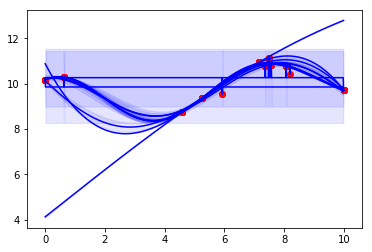

In [6]:
# Generate data
f_true = sin
X, y = generate_data(n=3, f=f_true)

# Range to optimize in
X_range = np.arange(0, 10, 0.01)
imgs = []

fig, ax = plt.subplots()

kernel = get_optimal_kernel(X=X, y=y)
_, img = plot_in_range(
    X_range=X_range,
    kernel=kernel,
    X=X,
    y=y,
    ax=ax,
    fig=fig
)
imgs.append(img)

for _ in range(10):
    kernel = get_optimal_kernel(X=X, y=y)
    X_sampled, y_sampled = sample_new_point(X=X, y=y, X_range=X_range, kernel=kernel)
    
    X = np.concatenate([X, X_sampled], axis=0)
    y = np.concatenate([y, y_sampled], axis=0)

    _, img = plot_in_range(
        X_range=X_range,
        kernel=kernel,
        X=X,
        y=y,
        ax=ax,
        fig=fig
    )
    imgs.append(img)

# ani = animation.ArtistAnimation(fig, imgs, interval=500, blit=False)
# HTML(ani.to_html5_video())

In [26]:
a = np.random.randint(0, high=100, size=(1000, 1000))

In [20]:
%timeit np.linalg.inv(a)

62.5 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
